Jakarta is the capital and largest city of Indonesia, a rapidly developing nation. One of their signs of development is a large public transportation network and will only continue to develop further assuming Jakarta maintains its position and increasing development after Indonesia moves their capital. One way to help improve revenue for public transportation would be to find the typical high revenue riders. For this project I attempt to predict how much money a passenger will yield based on the premises of their first check in, at least of within the month of April since that's the data I am given. Also it's important to note this is synthetic data, and couldn't find the original source and also there's a monthly ticket subscription effectively creating lots of free rides.

Source: https://www.kaggle.com/datasets/dikisahkan/transjakarta-transportation-transaction 

# Import #

In [2916]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import RidgeCV, LassoCV,ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
pd.set_option('display.max_columns', None)

# Cleaning and prepping #

In [2917]:
df = pd.read_csv(r"C:\Users\nicks\OneDrive\Desktop\VSprojects\Jakartatransport\dftabledontround.csv")

In [2918]:
df

,OID_,transID,payCardID,payCardBank,payCardName,payCardSex,payCardBirthDate,corridorID,corridorName,direction,tapInStops,tapInStopsName,tapInStopsLat,tapInStopsLon,stopStartSeq,tapInTime,tapOutStops,tapOutStopsName,tapOutStopsLat,tapOutStopsLon,stopEndSeq,tapOutTime,payAmount,OBJECTID,Join_Count,TARGET_FID,Number,Name
0,1,VRPJ892P3M98RA,3.561408e+15,dki,"Dr. Janet Nashiruddin, M.Ak",M,2010,4,Pulo Gadung 2 - Tosari,1,P00167,Pemuda Rawamangun,-6.193488,106.891650,12,4/3/2023 6:53,P00127,Layur,-6.193539,106.899090,13.0,4/3/2023 7:13,3500.0,1,1,1,8,PULO GADUNG
1,2,ZWCH834I6M26HS,3.477281e+14,emoney,Balamantri Rahayu,M,2002,JAK.28,Kp. Rambutan - Taman Wiladatika,1,B04633P,Sekolah Islam PB Soedirman,-6.314293,106.862980,27,4/3/2023 5:59,B00865P,Jln. Ar Ridho,-6.308148,106.869350,30.0,4/3/2023 6:57,0.0,2,1,2,13,CIRACAS
2,3,YRLD835V6L82GO,3.771055e+14,emoney,Dian Mustofa,F,1993,B13,Bekasi Barat - Blok M,1,B02192P,Mall Metropolitan,-6.247861,106.992150,6,4/3/2023 5:13,B00108P,Bandar Djakarta Bekasi,-6.227085,106.996830,9.0,4/3/2023 6:01,20000.0,3,0,3,0,outside
3,4,ZZBX143N6N83HQ,4.486493e+15,dki,"Cut Janet Suryatmi, M.Ak",M,1980,8K,Batusari - Grogol,1,B03637P,Sbr. Jln. Angsana Kemanggisan,-6.194813,106.782130,16,4/3/2023 5:20,NaN,Yayasan Alkahfi Jakbar,-6.198896,106.768890,26.0,4/3/2023 6:01,3500.0,4,1,4,28,PALMERAH
4,5,EWEG491A2W45DR,3.013938e+13,bni,"dr. Mulyanto Pudjiastuti, M.Ak",F,1997,NaN,NaN,0,NaN,BRI Menteng,-6.186792,106.835140,2,4/3/2023 6:00,B02755P,Perpustakaan Nasional,-6.180673,106.826430,5.0,4/3/2023 6:47,3500.0,5,1,5,38,MENTENG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189495,189496,AEQP180C2Q77IS,3.782543e+14,emoney,"R.A. Malika Samosir, S.Kom",M,1998,JAK.43B,Tongtek - Tebet Eco Park (TEP) - Cililitan,1,B06271P,Simpang Tebet Raya Timur 1,-6.229718,106.852860,24,4/2/2023 13:00,B03318P,Sawo Kecik Raya,-6.224852,106.854890,34.0,4/2/2023 14:54,0.0,189496,1,189496,15,TEBET
189496,189497,PJOF006Z8Q63II,5.406088e+15,dki,Amalia Gunarto,M,1981,9C,Pinang Ranti - Bundaran Senayan,1,P00040,Cikoko Stasiun Cawang Arah Timur,-6.243028,106.858140,9,4/4/2023 17:31,P00030,Cawang Ciliwung Arah Timur,-6.243012,106.863540,10.0,4/4/2023 18:38,3500.0,189497,1,189497,15,TEBET
189497,189498,NTSG621H8U49WW,4.674675e+18,brizzi,R.A. Lintang Wibisono,F,1998,6T,Pasar Minggu - Velbak,1,B06746P,Sbr. Jln. Pangeran Antasari,-6.275209,106.808665,17,4/5/2023 10:37,B06750P,Sbr. SDN Cilandak Barat 15,-6.288628,106.806811,19.0,4/5/2023 12:20,3500.0,189498,1,189498,21,CILANDAK
189498,189499,PUNA543S2M10LX,4.952763e+12,online,Yunita Sitompul,F,1984,2,Pulo Gadung - Monas,1,P00005,ASMI,-6.171797,106.888800,12,4/14/2023 13:34,P00192,Pulo Gadung 1,-6.183239,106.909070,15.0,4/14/2023 16:05,3500.0,189499,1,189499,6,KELAPA GADING


In [2919]:
#Lowercasing, renaming, and dropping redudnant columns
df.columns = map(str.lower, df.columns)
df = df.rename({'number': 'area'}, axis = 1)
df = df.drop(['transid', 'tapoutstopsname', 'tapinstopsname'], axis=1)

In [2920]:
#Drop NaNs
df = df.dropna()

In [2921]:
#Sorting by time, will be helpful for filtering out non-1sts
df = df.sort_values(by='tapintime')

In [2922]:
#Grouping birth year into decades
df['birth_decade'] = (df['paycardbirthdate'] // 10 * 10).astype(str)

In [2923]:
#Getting airport stop based on coordinates
df['airport'] = (df['tapinstopslat'] == -6.109565) & (df['tapinstopslon'] == 106.68406).astype(int)

In [2924]:
df['tapintime'] = pd.to_datetime(df['tapintime'])

df['tapouttime'] = pd.to_datetime(df['tapouttime'])
#Getting day, weekday, and hour of each tapintime
df['hourin'] = df['tapintime'].dt.hour.astype(str)
df['dayofweekin'] = df['tapintime'].dt.day_name()
df['day'] = df['tapintime'].dt.day.astype(int)

df['hourout'] = df['tapouttime'].dt.hour.astype(str)
df['dayofweekout'] = df['tapouttime'].dt.day_name()

In [2925]:
#Marking if bus code has B...P
df['inbp'] = df['tapinstops'].str.contains('B').astype(int)
df['outbp'] = df['tapoutstops'].str.contains('B').astype(int)

In [2926]:
df['tapinstops'] = df['tapinstops'].str.replace('[^0-9]', '', regex=True)
df['tapoutstops'] = df['tapoutstops'].str.replace('[^0-9]', '', regex=True)

In [2927]:
df['tapinstops'] = (df['tapinstops'].astype(int) // 10 * 10).astype(str).str.pad(5, fillchar='0')
df['tapoutstops'] = (df['tapoutstops'].astype(int) // 10 * 10).astype(str).str.pad(5, fillchar='0')

In [2928]:
#Most common tapinstop
most_common_tapinstops = df.groupby('paycardid')['tapinstops'].agg(lambda x: x.mode()[0]).reset_index()
most_common_tapinstops.rename(columns={'tapinstops': 'most_common_tapinstops'}, inplace=True)

df = df.merge(most_common_tapinstops, on='paycardid', how='left')

In [2929]:
df

,oid_,paycardid,paycardbank,paycardname,paycardsex,paycardbirthdate,corridorid,corridorname,direction,tapinstops,tapinstopslat,tapinstopslon,stopstartseq,tapintime,tapoutstops,tapoutstopslat,tapoutstopslon,stopendseq,tapouttime,payamount,objectid,join_count,target_fid,area,name,birth_decade,airport,hourin,dayofweekin,day,hourout,dayofweekout,inbp,outbp,most_common_tapinstops
0,188488,3.528232e+15,dki,Ade Permata,F,1995,12P,St. LRT Pegangsaan Dua - JIS,1,06070,-6.130291,106.86142,3,2023-04-01 10:51:00,00240,-6.142900,106.890760,8.0,2023-04-01 11:20:00,3500.0,188488,1,188488,5,TANJUNGPRIOK,1990,False,10,Saturday,1,11,Saturday,1,0,06070
1,188644,4.078028e+15,dki,"H. Laswi Setiawan, S.Kom",M,2011,JAK.25,Kp. Rambutan - Kalisari,0,01020,-6.338531,106.86000,45,2023-04-01 10:54:00,04090,-6.339658,106.863530,47.0,2023-04-01 12:12:00,0.0,188644,1,188644,14,PASAR REBO,2010,False,10,Saturday,1,12,Saturday,1,1,01020
2,188558,4.996204e+12,online,Yono Uwais,M,1981,12A,Pelabuhan Kaliadem - Kota,1,02650,-6.116367,106.77824,14,2023-04-01 11:06:00,05250,-6.115644,106.775060,15.0,2023-04-01 12:58:00,3500.0,188558,1,188558,30,PENJARINGAN,1980,False,11,Saturday,1,12,Saturday,1,1,02650
3,188638,4.297313e+18,brizzi,Wardaya Budiyanto,F,1972,7E,Kampung Rambutan - Ragunan,1,01370,-6.306793,106.87756,17,2023-04-01 11:13:00,00100,-6.309885,106.882160,19.0,2023-04-01 11:47:00,3500.0,188638,1,188638,13,CIRACAS,1970,False,11,Saturday,1,11,Saturday,1,0,01370
4,189250,6.514102e+15,dki,Umi Mulyani,M,1987,JAK.59,Rawamangun - Tanah Merah,1,05090,-6.178746,106.88560,10,2023-04-01 11:16:00,00070,-6.172158,106.888940,12.0,2023-04-01 13:34:00,0.0,189250,1,189250,8,PULO GADUNG,1980,False,11,Saturday,1,13,Saturday,1,1,05090
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153958,161440,4.417275e+18,brizzi,"Yunita Puspasari, S.Ked",F,1985,JAK.112,Terminal Tanah Merah - Pulo Gadung,0,01240,-6.144495,106.90988,2,2023-04-09 09:57:00,03000,-6.182228,106.909010,26.0,2023-04-09 11:17:00,0.0,161440,1,161440,6,KELAPA GADING,1980,False,9,Sunday,9,11,Sunday,1,1,01240
153959,161063,5.444860e+15,dki,Paulin Agustina,M,1978,2E,Rusun Rawa Bebek - Kodamar,0,05300,-6.206887,106.93519,9,2023-04-09 09:57:00,03000,-6.174677,106.892419,28.0,2023-04-09 10:29:00,0.0,161063,1,161063,4,CAKUNG,1970,False,9,Sunday,9,10,Sunday,1,1,00080
153960,162568,4.372731e+15,dki,"drg. Cemplunk Saefullah, S.Kom",F,2012,4C,TU Gas - Bundaran Senayan,0,00120,-6.193539,106.89909,1,2023-04-09 09:58:00,05810,-6.203214,106.845575,13.0,2023-04-09 11:28:00,3500.0,162568,1,162568,8,PULO GADUNG,2010,False,9,Sunday,9,11,Sunday,0,1,00120
153961,162912,5.305751e+15,dki,"Vega Halimah, M.Pd",M,1997,BW9,Monas - Pantai Indah Kapuk,0,00190,-6.107998,106.73942,3,2023-04-09 09:58:00,06900,-6.089429,106.741383,6.0,2023-04-09 11:52:00,0.0,162912,1,162912,30,PENJARINGAN,1990,False,9,Sunday,9,11,Sunday,1,1,00190


In [2930]:
#Getting total future payment and dropping duplicates, first payment is saved.
dfupdated = df.groupby('paycardid')['payamount'].sum()
df = df.merge(dfupdated, on='paycardid', suffixes=('', '_total'))
df = df.drop_duplicates(subset = 'paycardid')

In [2931]:
df

,oid_,paycardid,paycardbank,paycardname,paycardsex,paycardbirthdate,corridorid,corridorname,direction,tapinstops,tapinstopslat,tapinstopslon,stopstartseq,tapintime,tapoutstops,tapoutstopslat,tapoutstopslon,stopendseq,tapouttime,payamount,objectid,join_count,target_fid,area,name,birth_decade,airport,hourin,dayofweekin,day,hourout,dayofweekout,inbp,outbp,most_common_tapinstops,payamount_total
0,188488,3.528232e+15,dki,Ade Permata,F,1995,12P,St. LRT Pegangsaan Dua - JIS,1,06070,-6.130291,106.86142,3,2023-04-01 10:51:00,00240,-6.142900,106.89076,8.0,2023-04-01 11:20:00,3500.0,188488,1,188488,5,TANJUNGPRIOK,1990,False,10,Saturday,1,11,Saturday,1,0,06070,3500.0
1,188644,4.078028e+15,dki,"H. Laswi Setiawan, S.Kom",M,2011,JAK.25,Kp. Rambutan - Kalisari,0,01020,-6.338531,106.86000,45,2023-04-01 10:54:00,04090,-6.339658,106.86353,47.0,2023-04-01 12:12:00,0.0,188644,1,188644,14,PASAR REBO,2010,False,10,Saturday,1,12,Saturday,1,1,01020,0.0
2,188558,4.996204e+12,online,Yono Uwais,M,1981,12A,Pelabuhan Kaliadem - Kota,1,02650,-6.116367,106.77824,14,2023-04-01 11:06:00,05250,-6.115644,106.77506,15.0,2023-04-01 12:58:00,3500.0,188558,1,188558,30,PENJARINGAN,1980,False,11,Saturday,1,12,Saturday,1,1,02650,3500.0
3,188638,4.297313e+18,brizzi,Wardaya Budiyanto,F,1972,7E,Kampung Rambutan - Ragunan,1,01370,-6.306793,106.87756,17,2023-04-01 11:13:00,00100,-6.309885,106.88216,19.0,2023-04-01 11:47:00,3500.0,188638,1,188638,13,CIRACAS,1970,False,11,Saturday,1,11,Saturday,1,0,01370,3500.0
4,189250,6.514102e+15,dki,Umi Mulyani,M,1987,JAK.59,Rawamangun - Tanah Merah,1,05090,-6.178746,106.88560,10,2023-04-01 11:16:00,00070,-6.172158,106.88894,12.0,2023-04-01 13:34:00,0.0,189250,1,189250,8,PULO GADUNG,1980,False,11,Saturday,1,13,Saturday,1,1,05090,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153958,189059,2.259640e+15,dki,Michelle Mangunsong,F,1955,3A,Rusun Pesakih - Kalideres,1,01790,-6.154249,106.70544,0,2023-04-09 08:35:00,01330,-6.155691,106.70774,1.0,2023-04-09 10:43:00,0.0,189059,1,189059,31,KALIDERES,1950,False,8,Sunday,9,10,Sunday,1,1,01790,0.0
153959,188258,4.865602e+15,dki,Hasta Mulyani,F,1989,JAK.33,Pulo Gadung - Kota,1,00850,-6.135162,106.83211,19,2023-04-09 08:40:00,00970,-6.176146,106.86188,53.0,2023-04-09 10:58:00,0.0,188258,1,188258,24,PADEMANGAN,1980,False,8,Sunday,9,10,Sunday,1,1,00850,0.0
153960,188582,2.242493e+15,dki,Karimah Lestari,F,1982,S31,Bintaro - Fatmawati,1,00220,-6.287529,106.77680,4,2023-04-09 08:42:00,00140,-6.286813,106.72865,5.0,2023-04-09 10:17:00,20000.0,188582,1,188582,18,KEBAYORAN LAMA,1980,False,8,Sunday,9,10,Sunday,1,1,00220,20000.0
153961,188900,4.391513e+18,brizzi,R. Jane Purwanti,F,1998,JAK.51,Taman Kota - Budi Luhur,0,02440,-6.200321,106.73181,19,2023-04-09 09:28:00,02970,-6.195419,106.74420,28.0,2023-04-09 12:12:00,0.0,188900,1,188900,32,KEMBANGAN,1990,False,9,Sunday,9,12,Sunday,1,1,02440,0.0


# Analyze #

In [2932]:
#Choosing variables and splitting em
from sklearn.model_selection import train_test_split
dfchoose = df[['paycardbank', 'paycardsex', 'birth_decade', 'hourin', 'hourout', 'dayofweekin', 'payamount_total', 'inbp', 'area', 'day', 'airport']]


x = dfchoose.drop('payamount_total', axis = 1)
y = dfchoose['payamount_total']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20)

In [2933]:
#Rejoining x and y for analysis's sake
x_trainy = x_train.join(y_train)


### Bank ###

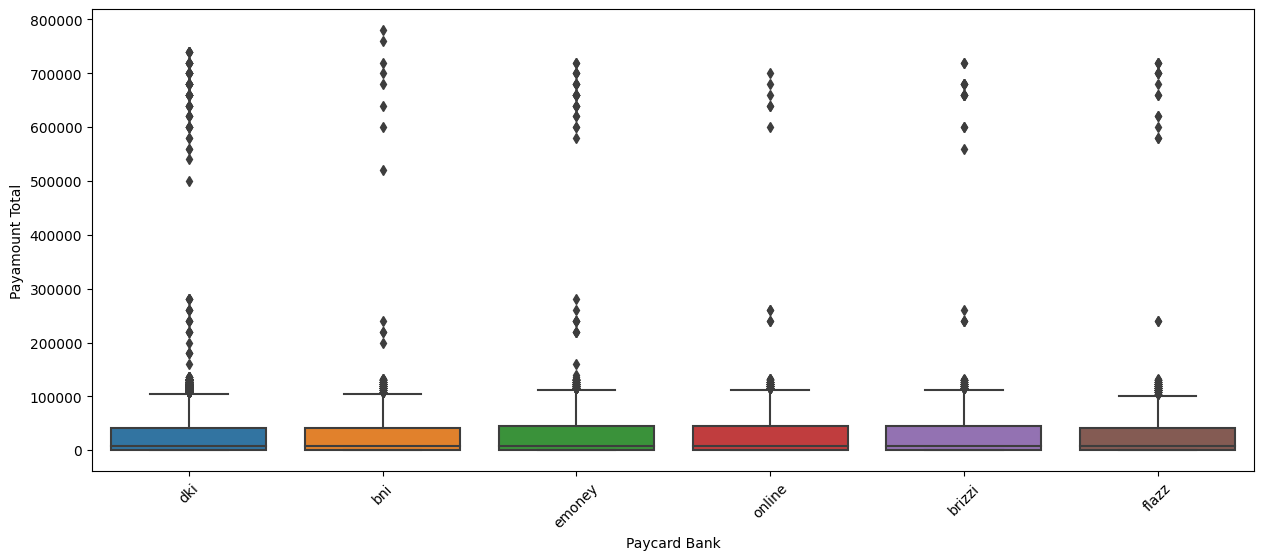

In [2934]:
order = ['dki', 'bni', 'emoney', 'online', 'brizzi', 'flazz']
plt.figure(figsize=(15,6))
sns.boxplot(x='paycardbank', y='payamount_total', data=x_trainy, order = order)
plt.xticks(rotation=45)
plt.xlabel('Paycard Bank')
plt.ylabel('Payamount Total')
plt.show()

c:\Users\nicks\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1500x600 with 0 Axes>

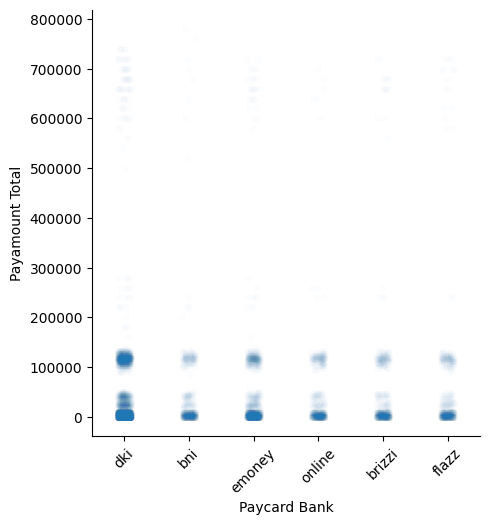

In [2935]:
plt.figure(figsize=(15,6))
sns.catplot(x='paycardbank', y='payamount_total', data=x_trainy, alpha = 0.01, order = order)
plt.xticks(rotation=45)
plt.xlabel('Paycard Bank')
plt.ylabel('Payamount Total')
plt.show()

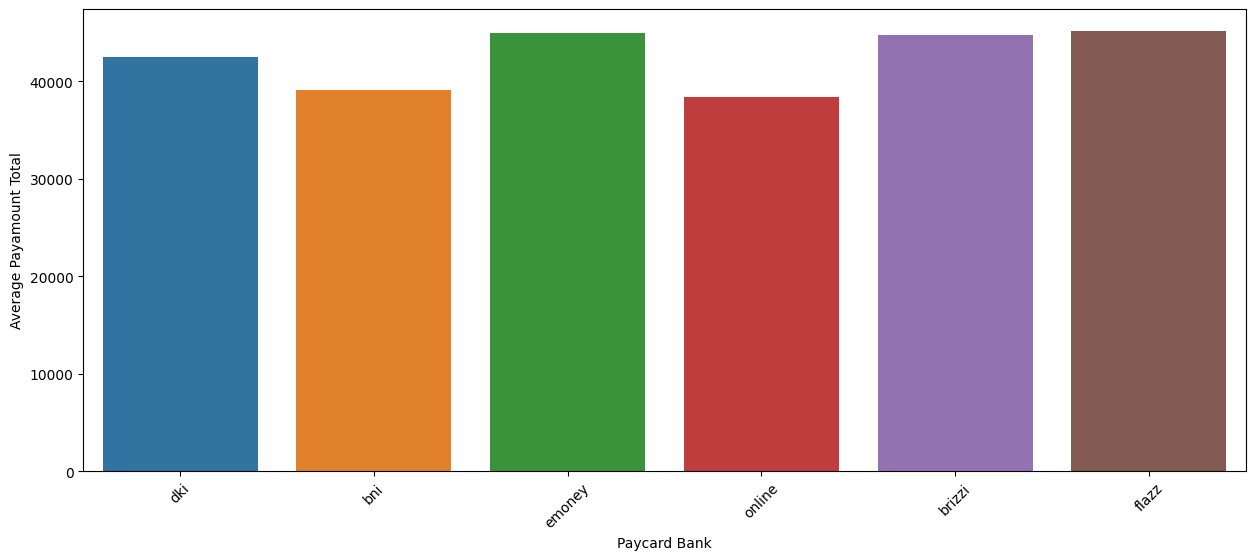

In [2936]:
bank_avg_payamount = x_trainy.groupby('paycardbank')['payamount_total'].mean()

plt.figure(figsize=(15,6))
sns.barplot(x=bank_avg_payamount.index, y=bank_avg_payamount.values, order = order)
plt.xticks(rotation=45)
plt.xlabel('Paycard Bank')
plt.ylabel('Average Payamount Total')
plt.show()

Bankcard doesn't really seam to matter much. Also would note dki would be most used judging by catplot color density.

### Gender ###

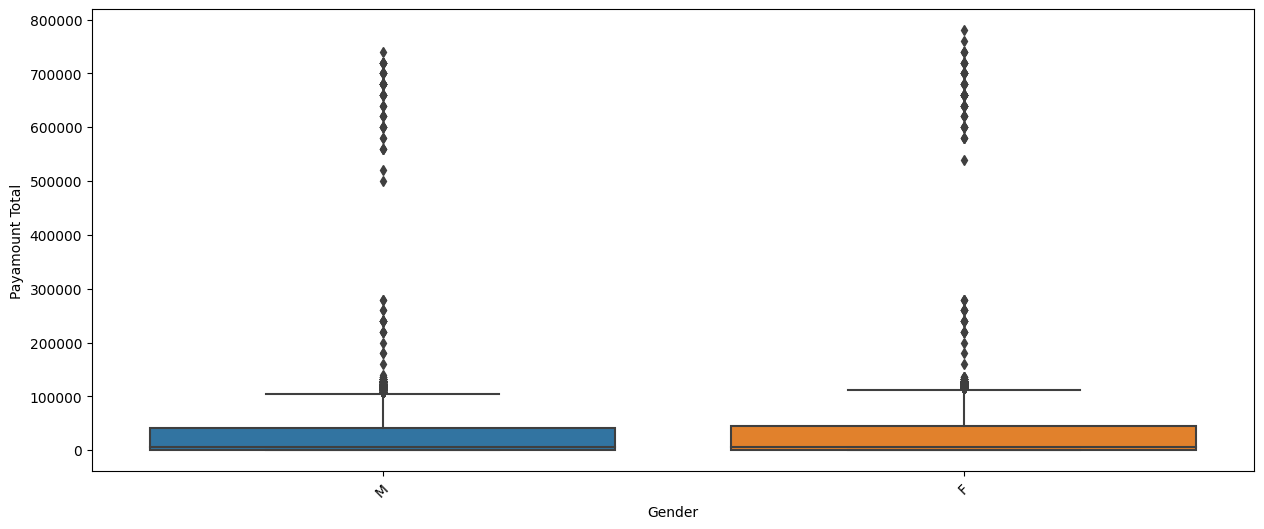

In [2937]:
order = ['M', 'F']
plt.figure(figsize=(15,6))
sns.boxplot(x='paycardsex', y='payamount_total', data=x_trainy, order = order)
plt.xticks(rotation=45)
plt.xlabel('Gender')
plt.ylabel('Payamount Total')
plt.show()

c:\Users\nicks\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1500x600 with 0 Axes>

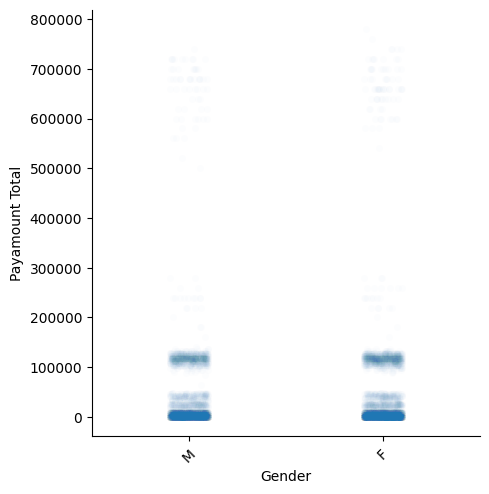

In [2938]:
plt.figure(figsize=(15,6))
sns.catplot(x='paycardsex', y='payamount_total', data=x_trainy, alpha = 0.01, order = order)
plt.xticks(rotation=45)
plt.xlabel('Gender')
plt.ylabel('Payamount Total')
plt.show()

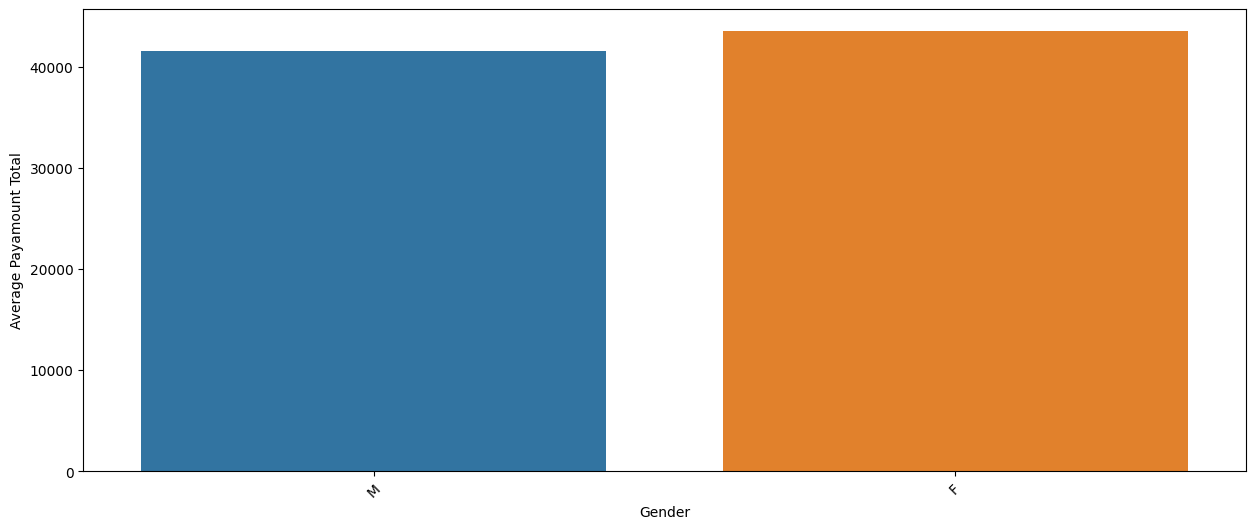

In [2939]:
bank_avg_payamount = x_trainy.groupby('paycardsex')['payamount_total'].mean()

plt.figure(figsize=(15,6))
sns.barplot(x=bank_avg_payamount.index, y=bank_avg_payamount.values, order = order)
plt.xticks(rotation=45)
plt.xlabel('Gender')
plt.ylabel('Average Payamount Total')
plt.show()

Nothing much to say about gender. No difference.

### Birth year ###

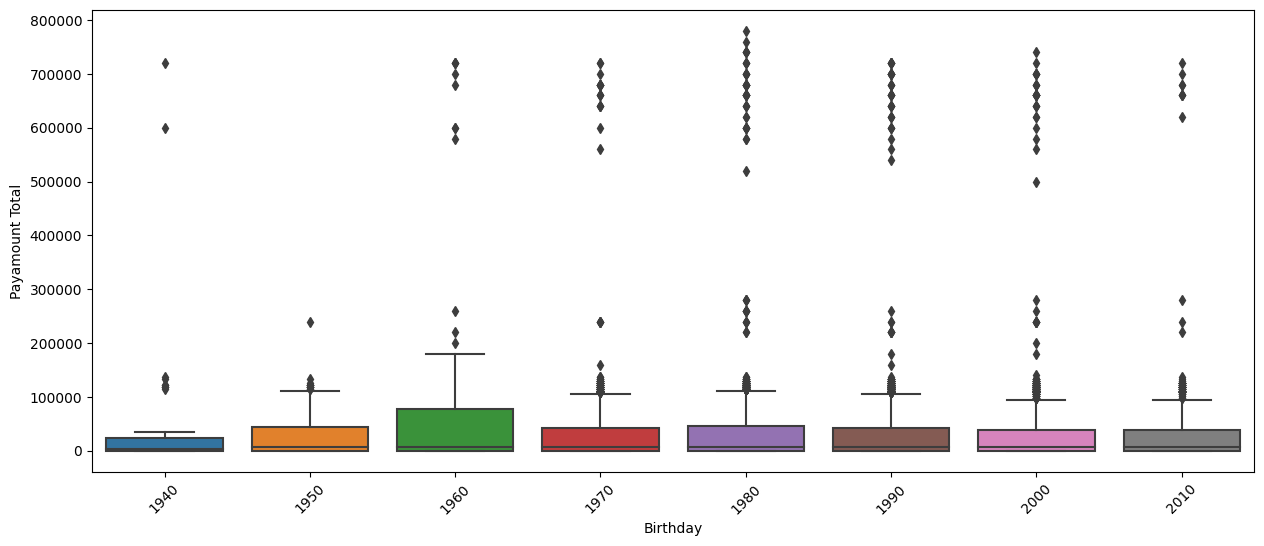

In [2940]:
order = ['1940', '1950', '1960', '1970', '1980', '1990', '2000', '2010']
plt.figure(figsize=(15,6))
sns.boxplot(x='birth_decade', y='payamount_total', data=x_trainy, order = order)
plt.xticks(rotation=45)
plt.xlabel('Birthday')
plt.ylabel('Payamount Total')
plt.show()

c:\Users\nicks\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1500x600 with 0 Axes>

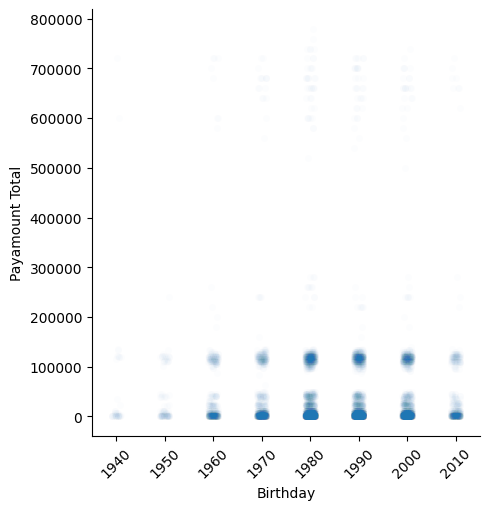

In [2941]:
plt.figure(figsize=(15,6))
sns.catplot(x='birth_decade', y='payamount_total', data=x_trainy, alpha = 0.01, order = order)
plt.xticks(rotation=45)
plt.xlabel('Birthday')
plt.ylabel('Payamount Total')
plt.show()

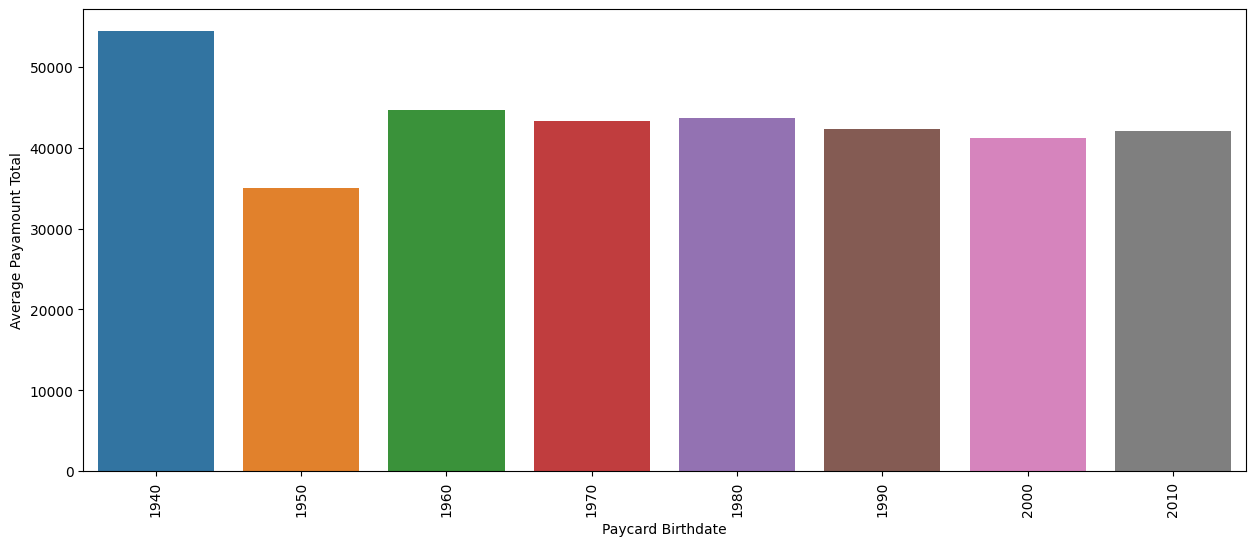

In [2942]:
birthdate_avg_payamount = x_trainy.groupby('birth_decade')['payamount_total'].mean()

# Plotting
plt.figure(figsize=(15,6))
sns.barplot(x=birthdate_avg_payamount.index, y=birthdate_avg_payamount.values, order = order)
plt.xticks(rotation=90)
plt.xlabel('Paycard Birthdate')
plt.ylabel('Average Payamount Total')
plt.show()

No statistical significance.

### Hour ###

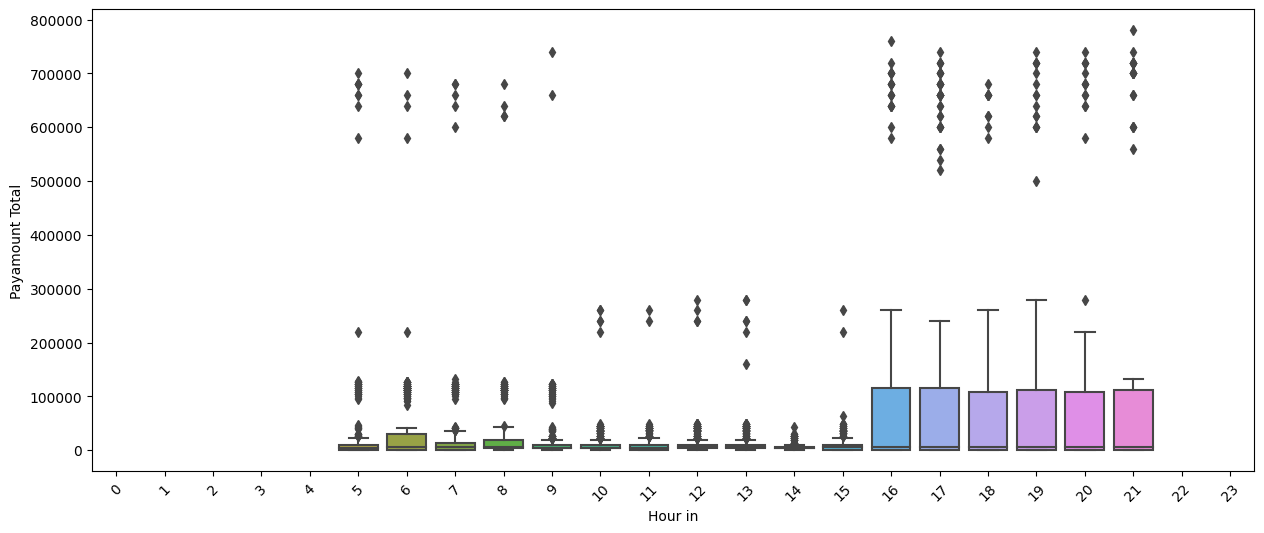

In [2943]:
order = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23']

plt.figure(figsize=(15,6))
sns.boxplot(x='hourin', y='payamount_total', data=x_trainy, order = order)
plt.xticks(rotation=45)
plt.xlabel('Hour in')
plt.ylabel('Payamount Total')
plt.show()

c:\Users\nicks\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1500x600 with 0 Axes>

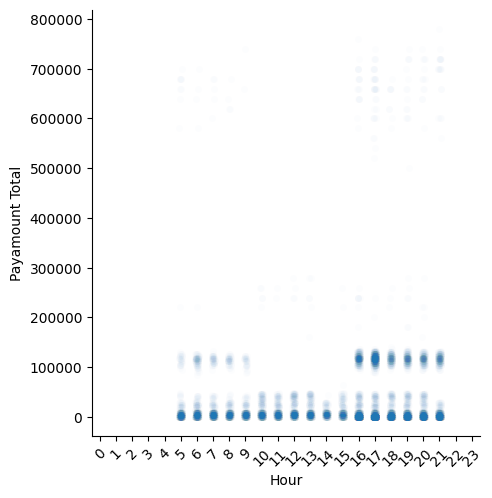

In [2944]:
plt.figure(figsize=(15,6))
sns.catplot(x='hourin', y='payamount_total', data=x_trainy, alpha = 0.01, order = order)
plt.xticks(rotation=45)
plt.xlabel('Hour')
plt.ylabel('Payamount Total')
plt.show()

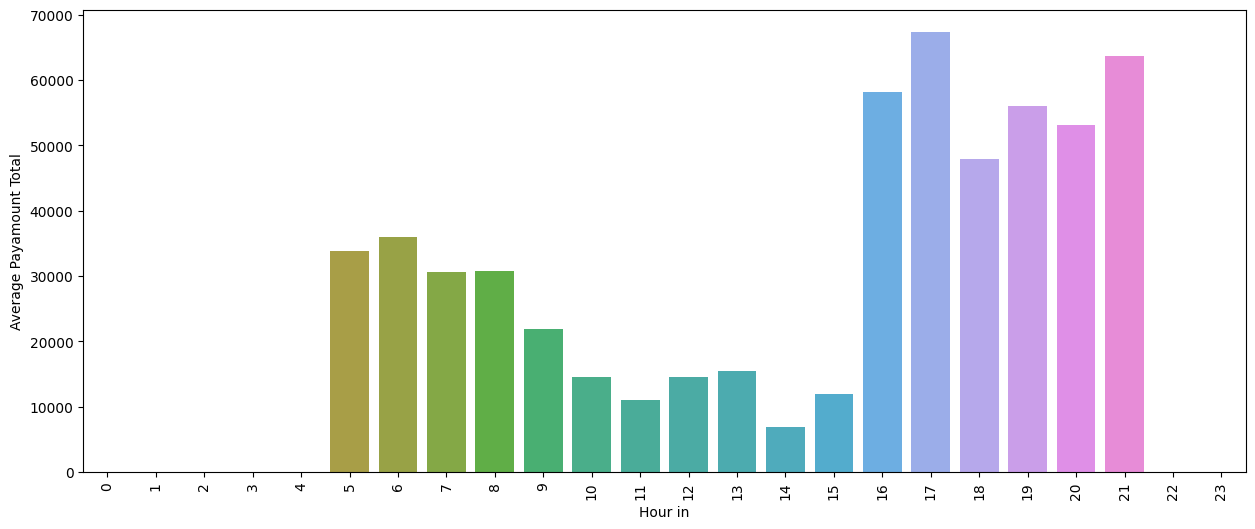

In [2945]:
birthdate_avg_payamount = x_trainy.groupby('hourin')['payamount_total'].mean()


plt.figure(figsize=(15,6))
sns.barplot(x=birthdate_avg_payamount.index, y=birthdate_avg_payamount.values, order = order)
plt.xticks(rotation=90)
plt.xlabel('Hour in')
plt.ylabel('Average Payamount Total')
plt.show()

Biggest spenders tend to be in the morning and evening. Evening I can see it's because they only use public transit when going out, which wouldn't be enough to make financial use of the monthly subscription. Not so sure about the extremely early birds, probably those people going home after partying all night?

### Weekday ###

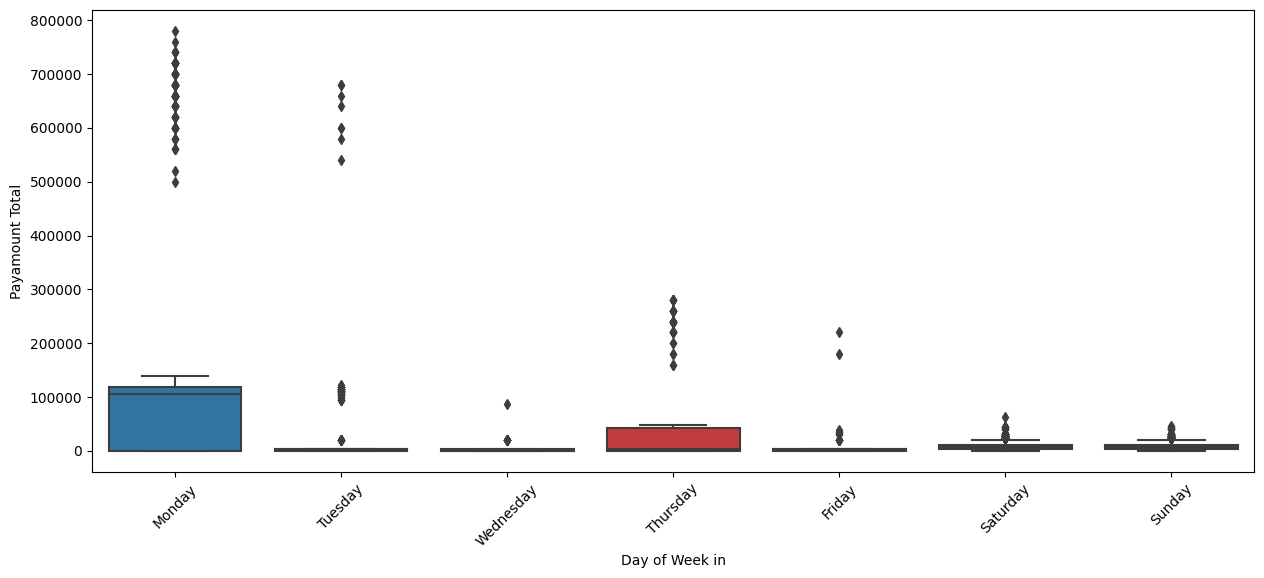

In [2946]:
order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

plt.figure(figsize=(15,6))
sns.boxplot(x='dayofweekin', y='payamount_total', data=x_trainy, order=order)
plt.xticks(rotation=45)
plt.xlabel('Day of Week in')
plt.ylabel('Payamount Total')
plt.show()

c:\Users\nicks\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1500x600 with 0 Axes>

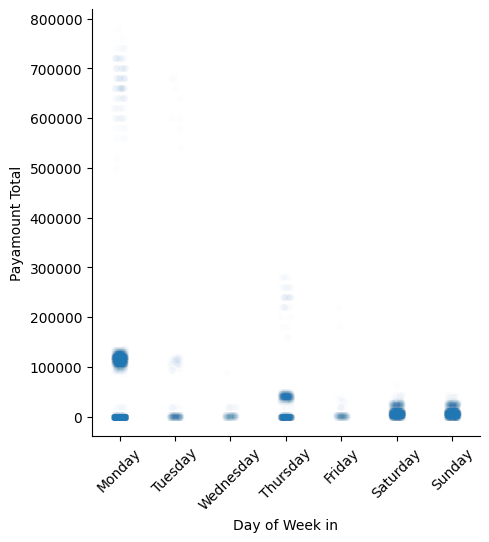

In [2947]:
plt.figure(figsize=(15,6))
sns.catplot(x='dayofweekin', y='payamount_total', data=x_trainy, alpha = 0.01, order = order)
plt.xticks(rotation=45)
plt.xlabel('Day of Week in')
plt.ylabel('Payamount Total')
plt.show()

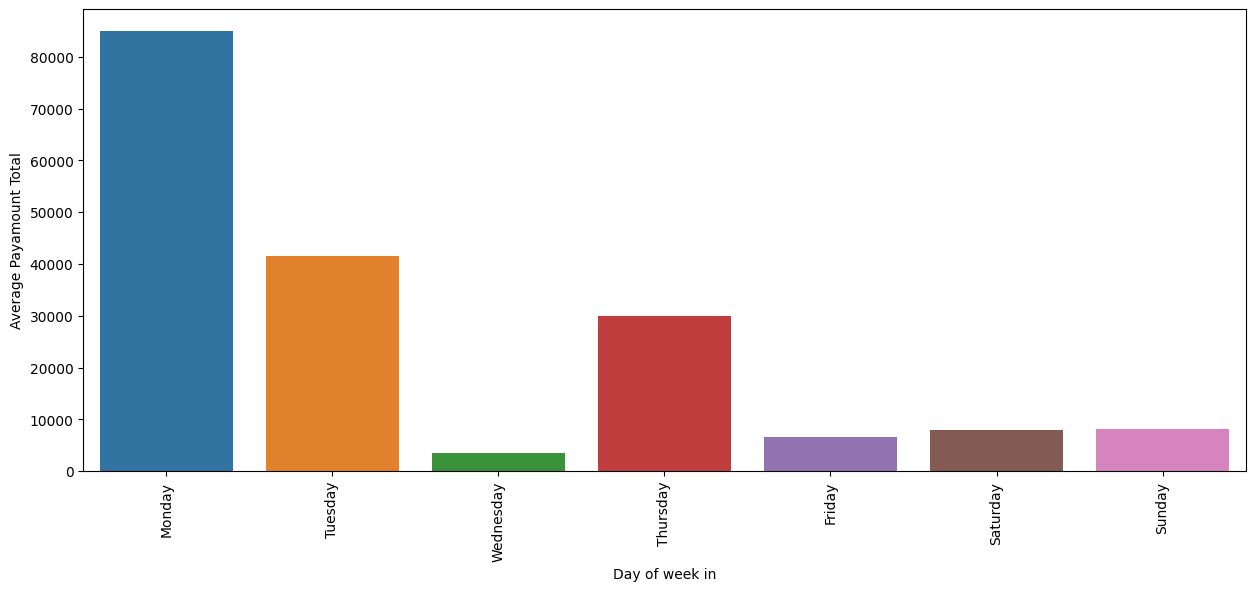

In [2948]:
birthdate_avg_payamount = x_trainy.groupby('dayofweekin')['payamount_total'].mean()
order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
# Plotting
plt.figure(figsize=(15,6))
sns.barplot(x=birthdate_avg_payamount.index, y=birthdate_avg_payamount.values, order = order)
plt.xticks(rotation=90)
plt.xlabel('Day of week in')
plt.ylabel('Average Payamount Total')
plt.show()

Monday spenders largest, likely because of the Eid value swing(see later). Same story for Tuesday and Thursday since the days line up with around Eid. Ignoring those days. Considering that it seems the weekend days are like what I explained in the evening. 

### inbp ###

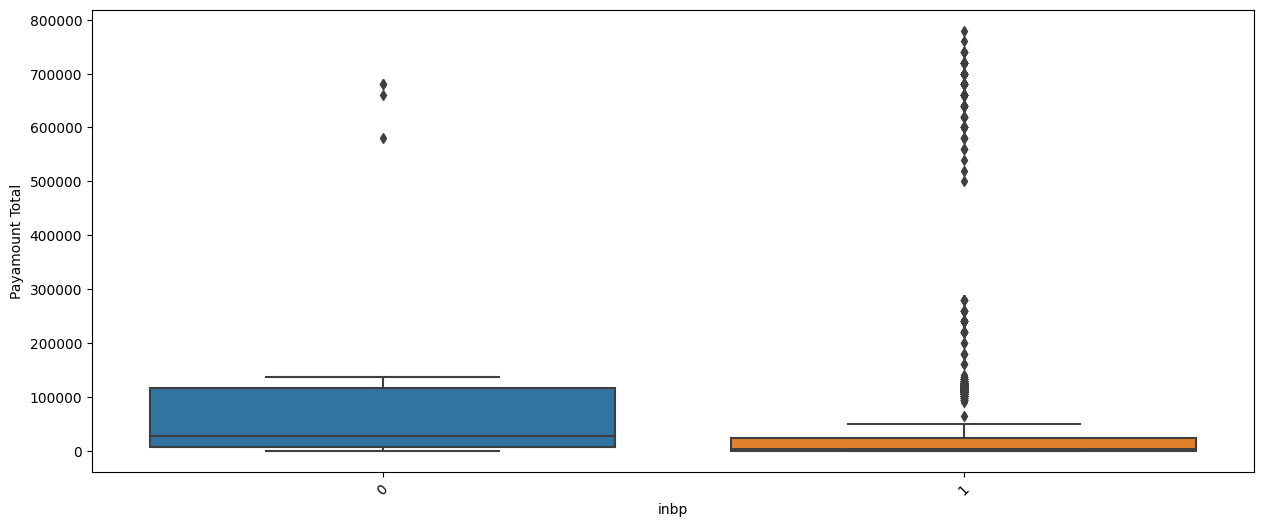

In [2949]:
order = [0, 1]
plt.figure(figsize=(15,6))
sns.boxplot(x='inbp', y='payamount_total', data=x_trainy, order = order)
plt.xticks(rotation=45)
plt.xlabel('inbp')
plt.ylabel('Payamount Total')
plt.show()

c:\Users\nicks\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1500x600 with 0 Axes>

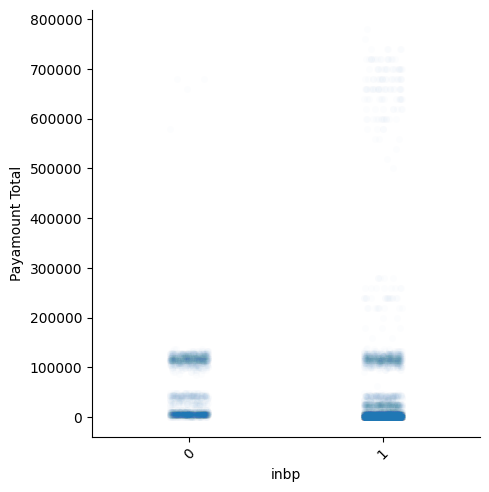

In [2950]:
plt.figure(figsize=(15,6))
sns.catplot(x='inbp', y='payamount_total', data=x_trainy, alpha = 0.01, order = order)
plt.xticks(rotation=45)
plt.xlabel('inbp')
plt.ylabel('Payamount Total')
plt.show()

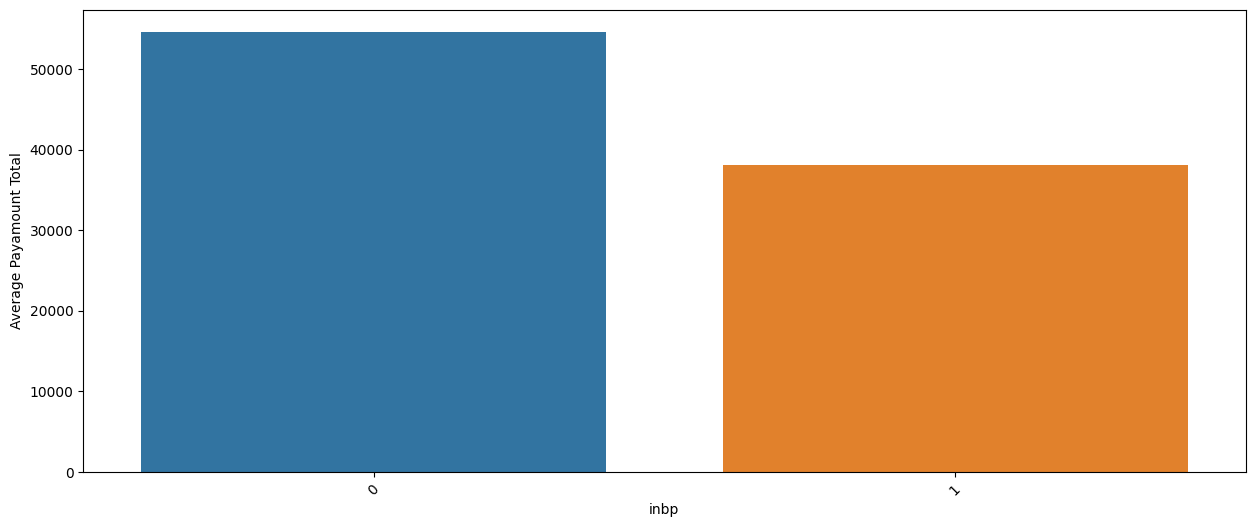

In [2951]:
bank_avg_payamount = x_trainy.groupby('inbp')['payamount_total'].mean()

plt.figure(figsize=(15,6))
sns.barplot(x=bank_avg_payamount.index, y=bank_avg_payamount.values, order = order)
plt.xticks(rotation=45)
plt.xlabel('inbp')
plt.ylabel('Average Payamount Total')
plt.show()

Higher paying users who use the tram or metro assuming B...P means bus. Can't tell exactly what those codes mean.

### Area ###

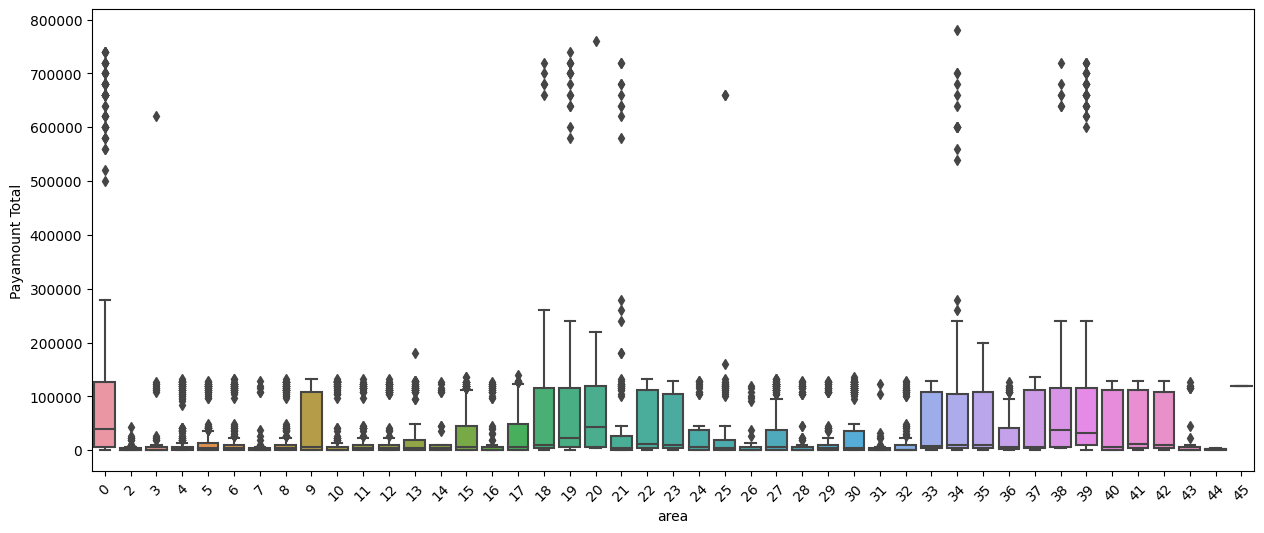

In [2952]:
order = sorted(df['area'].unique())
plt.figure(figsize=(15,6))
sns.boxplot(x='area', y='payamount_total', data=x_trainy, order = order)
plt.xticks(rotation=45)
plt.xlabel('area')
plt.ylabel('Payamount Total')
plt.show()

c:\Users\nicks\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1500x600 with 0 Axes>

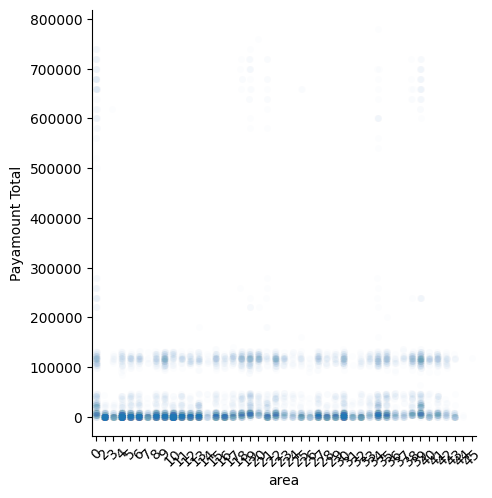

In [2953]:
plt.figure(figsize=(15,6))
sns.catplot(x='area', y='payamount_total', data=x_trainy, alpha = 0.01, order = order)
plt.xticks(rotation=45)
plt.xlabel('area')
plt.ylabel('Payamount Total')
plt.show()

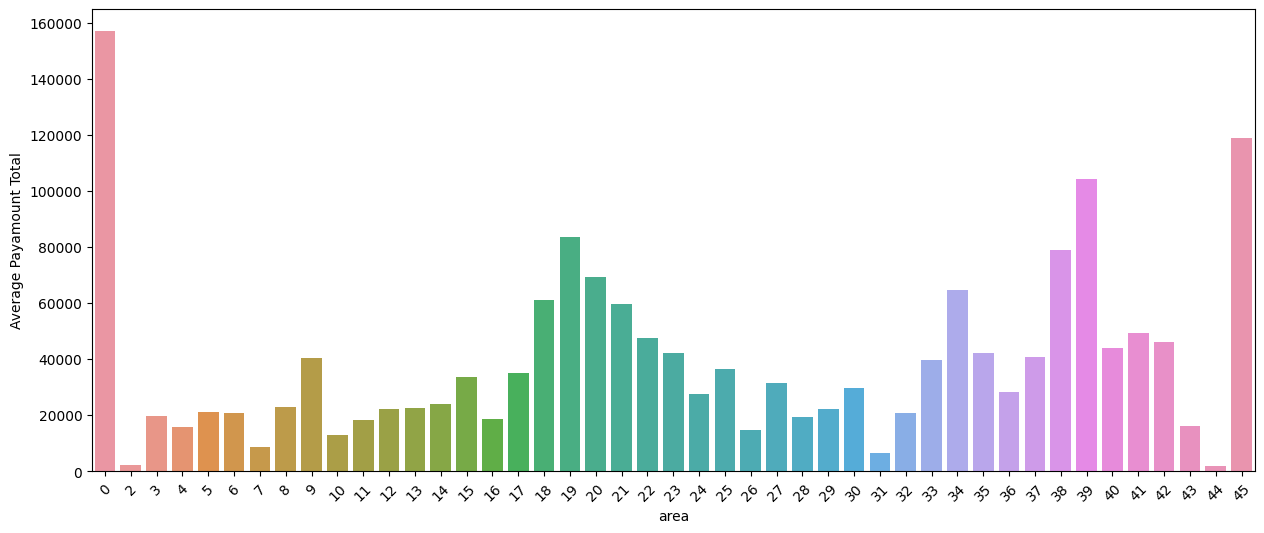

In [2954]:
bank_avg_payamount = x_trainy.groupby('area')['payamount_total'].mean()

plt.figure(figsize=(15,6))
sns.barplot(x=bank_avg_payamount.index, y=bank_avg_payamount.values, order = order)
plt.xticks(rotation=45)
plt.xlabel('area')
plt.ylabel('Average Payamount Total')

plt.show()

Largest spenders are outside Jakarta, could be a result of the travellers(spoiler alert: no). Highest spending areas(19,20, 39, 38, 34) are all concentrated in the central area. That area appears to be the business district, which could have some factor, or more importantly, there's a football stadium and grand mosque there, where public transport could be used more, and temporarily enough to not go for subscriptions. Map below for reference.

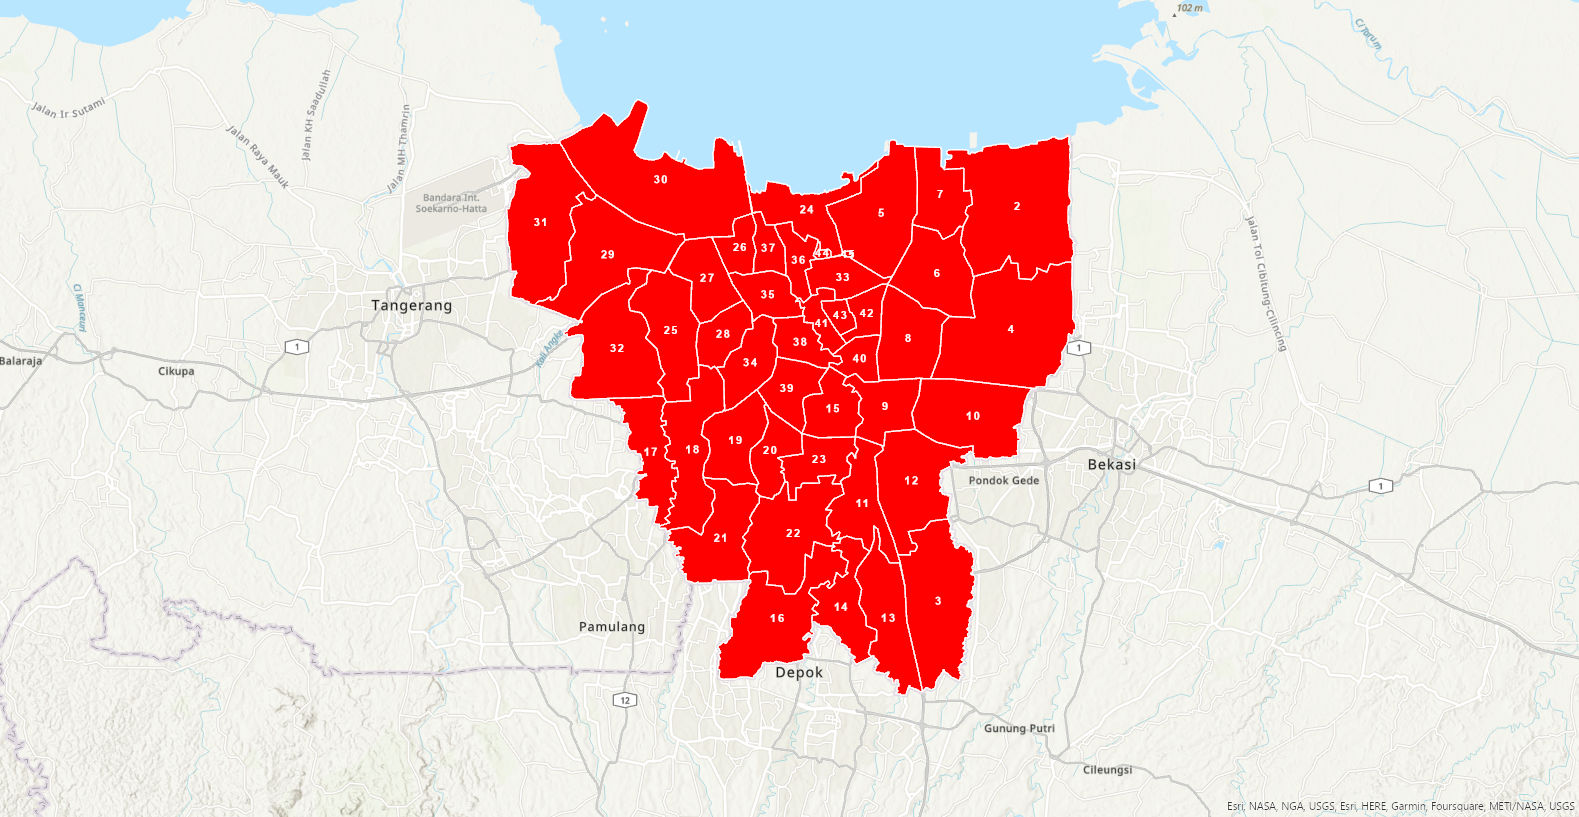

### Airport ###

In [2955]:
x_trainy[x_trainy['airport'] == 1]

,paycardbank,paycardsex,birth_decade,hourin,hourout,dayofweekin,inbp,area,day,airport,payamount_total
50690,online,M,2010,17,19,Monday,1,0,10,True,0.0
146856,dki,F,2000,10,11,Sunday,1,0,16,True,3500.0


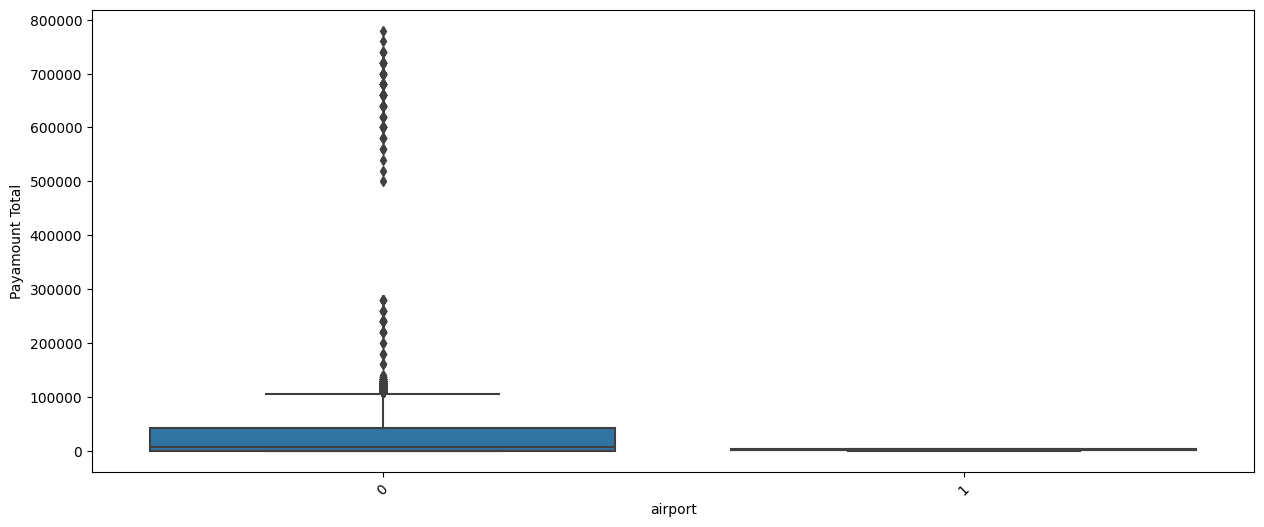

In [2956]:
order = [0, 1]
plt.figure(figsize=(15,6))
sns.boxplot(x='airport', y='payamount_total', data=x_trainy, order = order)
plt.xticks(rotation=45)
plt.xlabel('airport')
plt.ylabel('Payamount Total')
plt.show()

c:\Users\nicks\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1500x600 with 0 Axes>

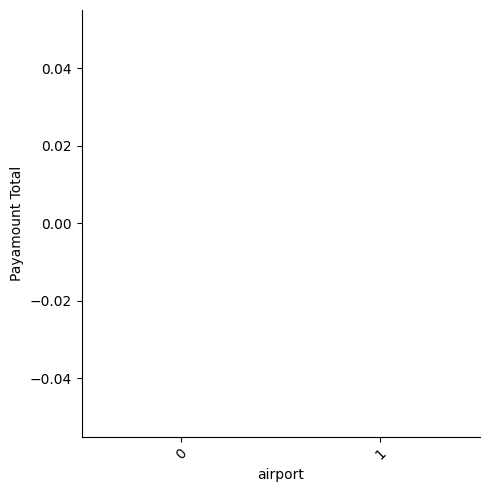

In [2957]:
plt.figure(figsize=(15,6))
sns.catplot(x='airport', y='payamount_total', data=x_trainy, alpha = 0.01, order = order)
plt.xticks(rotation=45)
plt.xlabel('airport')
plt.ylabel('Payamount Total')
plt.show()

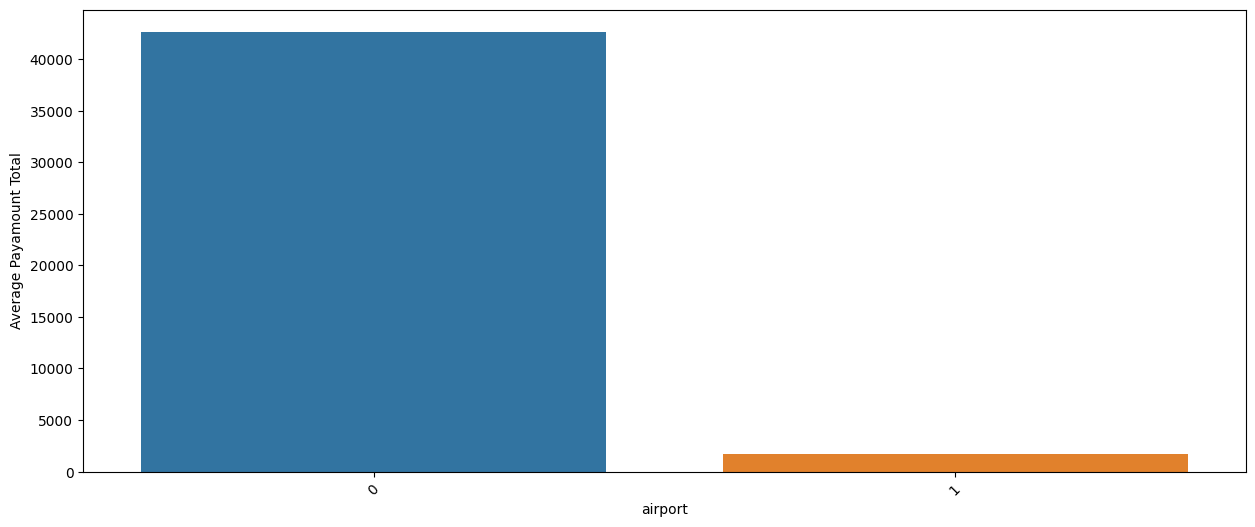

In [2958]:
bank_avg_payamount = x_trainy.groupby('airport')['payamount_total'].mean()

plt.figure(figsize=(15,6))
sns.barplot(x=bank_avg_payamount.index, y=bank_avg_payamount.values, order = order)
plt.xticks(rotation=45)
plt.xlabel('airport')
plt.ylabel('Average Payamount Total')
plt.show()

The stop closest to the airport appears to not be the airport stop judging by the volume. Taking a closer look at the maps the stop is in a neighborhood that happens to be next to the airport, which wouldn't make any sense to make it the go to stop for travellers. No idea why people outside Jakarta pay so much more then.

### Day ###

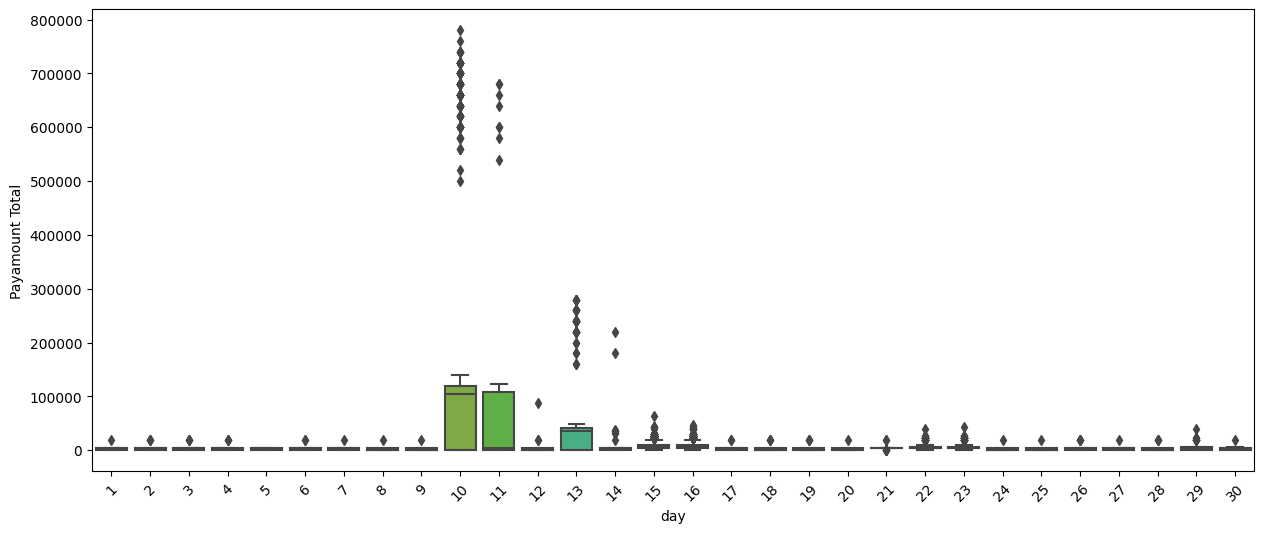

In [2959]:
order = sorted(df['day'].unique())
plt.figure(figsize=(15,6))
sns.boxplot(x='day', y='payamount_total', data=x_trainy, order = order)
plt.xticks(rotation=45)
plt.xlabel('day')
plt.ylabel('Payamount Total')
plt.show()

c:\Users\nicks\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1500x600 with 0 Axes>

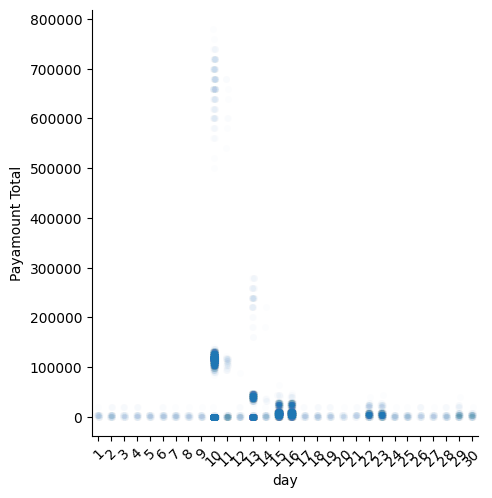

In [2960]:
plt.figure(figsize=(15,6))
sns.catplot(x='day', y='payamount_total', data=x_trainy, alpha = 0.01, order = order)
plt.xticks(rotation=45)
plt.xlabel('day')
plt.ylabel('Payamount Total')
plt.show()

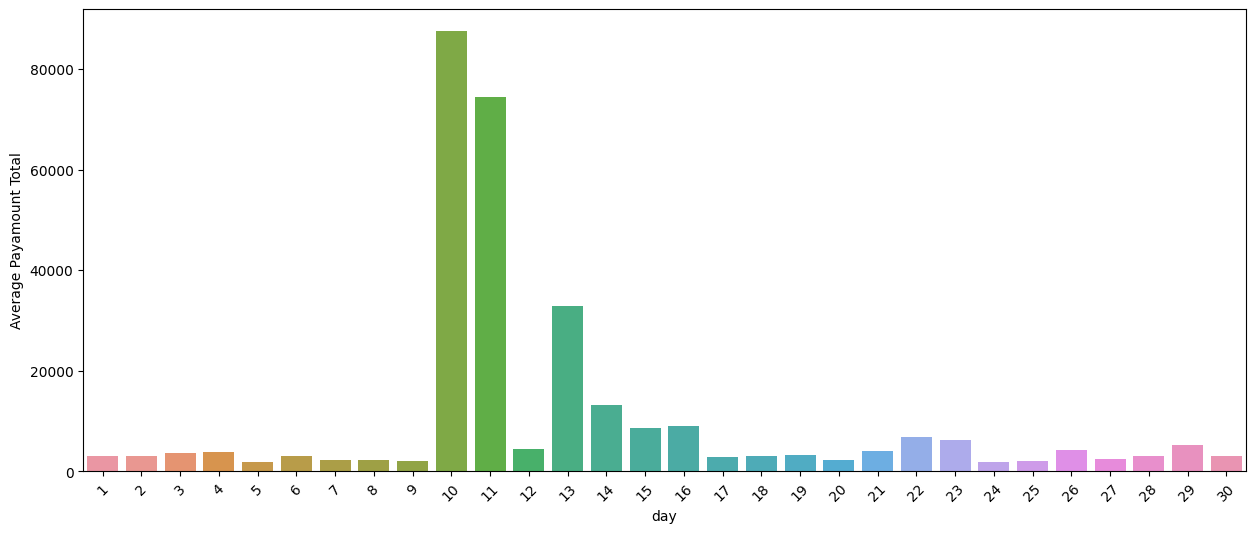

In [2961]:
bank_avg_payamount = x_trainy.groupby('day')['payamount_total'].mean()

plt.figure(figsize=(15,6))
sns.barplot(x=bank_avg_payamount.index, y=bank_avg_payamount.values, order = order)
plt.xticks(rotation=45)
plt.xlabel('day')
plt.ylabel('Average Payamount Total')
plt.show()

Extreme spike in customer value on 10th and 11th and 13th. Apparently those days are part of Eid al Fitr, at the importance level of Ramadan. 10th is the only day with real statistical significance, others are noise or strangely 0.

### Other ###

In [2962]:
def categorical_relationship(data):
    for col in data.columns:

        contingency_table = pd.crosstab(data[col], data['payamount_total'])
        

        chi2, p, dof, expected = chi2_contingency(contingency_table)

        
        print('-----------------------')
        print(col)
        print(p)
        print(type(p))

In [2963]:
#Onehot encoding
x_trainencode = pd.get_dummies(x_train, columns = ['paycardbank', 'paycardsex', 'birth_decade', 'hourin', 'dayofweekin', 'day', 'area', 'airport'], dtype = 'float32')
x_testencode = pd.get_dummies(x_test, columns = ['paycardbank', 'paycardsex', 'birth_decade', 'hourin', 'dayofweekin', 'day', 'area', 'airport'], dtype = 'float32')
print(len(x_trainencode.columns))

119


In [2964]:
#Combining x and y for ease, will remove y later.
x_trainencodey = x_trainencode.join(y_train.astype(str))
x_testencodey = x_testencode.join(y_test.astype(str))

#Getting p scores for each onehotted variable
categorical_relationship(x_trainencodey)

-----------------------
hourout
3.457473205375815e-118
<class 'numpy.float64'>
-----------------------
inbp
0.0
<class 'numpy.float64'>
-----------------------
paycardbank_bni
0.021676166863942484
<class 'numpy.float64'>
-----------------------
paycardbank_brizzi
0.5859530341702776
<class 'numpy.float64'>
-----------------------
paycardbank_dki
0.3364426643022868
<class 'numpy.float64'>
-----------------------
paycardbank_emoney
0.9008687523730857
<class 'numpy.float64'>
-----------------------
paycardbank_flazz
0.44171603356695827
<class 'numpy.float64'>
-----------------------
paycardbank_online
0.9889392037735362
<class 'numpy.float64'>
-----------------------
paycardsex_F
0.4821851572678456
<class 'numpy.float64'>
-----------------------
paycardsex_M
0.48218515726784583
<class 'numpy.float64'>
-----------------------
birth_decade_1940
0.38223664867400886
<class 'numpy.float64'>
-----------------------
birth_decade_1950
0.9529734771787448
<class 'numpy.float64'>
--------------------

In [2965]:
x_trainencodey['payamount_total'] = x_trainencodey['payamount_total'].astype(float)
x_testencodey['payamount_total'] = x_testencodey['payamount_total'].astype(float)

In [2966]:
count = 0

#Getting rid of variables which aren't present in both train and test. Wouldn't be significant anyways.
names = []
for name in x_testencodey.columns:
    if (name in x_trainencodey.columns) and (name in x_testencodey.columns):
        names.append(name)
    else:
        x_testencodey = x_testencodey.drop([name], axis = 1)

for name in x_trainencodey.columns:
    if name not in x_testencodey.columns:
        x_trainencodey = x_trainencodey.drop([name], axis = 1)


In [2967]:
names

['hourout',
 'inbp',
 'paycardbank_bni',
 'paycardbank_brizzi',
 'paycardbank_dki',
 'paycardbank_emoney',
 'paycardbank_flazz',
 'paycardbank_online',
 'paycardsex_F',
 'paycardsex_M',
 'birth_decade_1940',
 'birth_decade_1950',
 'birth_decade_1960',
 'birth_decade_1970',
 'birth_decade_1980',
 'birth_decade_1990',
 'birth_decade_2000',
 'birth_decade_2010',
 'hourin_10',
 'hourin_11',
 'hourin_12',
 'hourin_13',
 'hourin_14',
 'hourin_15',
 'hourin_16',
 'hourin_17',
 'hourin_18',
 'hourin_19',
 'hourin_20',
 'hourin_21',
 'hourin_5',
 'hourin_6',
 'hourin_7',
 'hourin_8',
 'hourin_9',
 'dayofweekin_Friday',
 'dayofweekin_Monday',
 'dayofweekin_Saturday',
 'dayofweekin_Sunday',
 'dayofweekin_Thursday',
 'dayofweekin_Tuesday',
 'dayofweekin_Wednesday',
 'day_1',
 'day_2',
 'day_3',
 'day_4',
 'day_5',
 'day_6',
 'day_7',
 'day_8',
 'day_9',
 'day_10',
 'day_11',
 'day_12',
 'day_13',
 'day_14',
 'day_15',
 'day_16',
 'day_17',
 'day_18',
 'day_19',
 'day_20',
 'day_21',
 'day_22',
 'd

In [2968]:

for col in names:

    contingency_table = pd.crosstab(x_trainencodey[col], x_trainencodey['payamount_total'])
    

    chi2, p, dof, expected = chi2_contingency(contingency_table)

    if (p >=.05) and (p>0):
        x_trainencodey = x_trainencodey.drop([col], axis = 1)
        x_testencodey = x_testencodey.drop([col], axis = 1)
        count+=1

In [2969]:
x_trainencodey = x_trainencodey.drop(['payamount_total'], axis = 1)
x_testencodey = x_testencodey.drop(['payamount_total'], axis = 1)

In [2970]:
nodecount = len(x_trainencodey.columns) #Getting variable count for neurons

# Neural Network #

We'll use Neural networks to predict the total payment of the conditions during the first purchase made, first one being 1 hidden layer and the next 2 hidden. The node counts represent the amount of variables used in the input, all of which are statistically significant. Relu is used because it is the most processing efficient.

In [2971]:
s_scaler = StandardScaler()
x_trainencodey = s_scaler.fit_transform(x_trainencodey)
x_testencodey = s_scaler.fit_transform(x_testencodey)

In [2972]:
model = Sequential()
model.add(Dense(nodecount,activation='relu'))
model.add(Dense(nodecount,activation='relu'))
model.add(Dense(1))
model.compile(optimizer='Adam',loss='mse')

model.fit(x=x_trainencodey,y=y_train,
          validation_data=(x_testencodey,y_test),
          batch_size=128,epochs=400)

y_pred = model.predict(x_testencodey)
print('VarScore:',metrics.explained_variance_score(y_test,y_pred))

Epoch 1/400


60/60 [==============================] - 1s 4ms/step - loss: 10976249856.0000 - val_loss: 12170565632.0000
Epoch 2/400
60/60 [==============================] - 0s 2ms/step - loss: 10972449792.0000 - val_loss: 12162252800.0000
Epoch 3/400
60/60 [==============================] - 0s 2ms/step - loss: 10955739136.0000 - val_loss: 12133530624.0000
Epoch 4/400
60/60 [==============================] - 0s 2ms/step - loss: 10911544320.0000 - val_loss: 12069042176.0000
Epoch 5/400
60/60 [==============================] - 0s 2ms/step - loss: 10825411584.0000 - val_loss: 11956756480.0000
Epoch 6/400
60/60 [==============================] - 0s 2ms/step - loss: 10685390848.0000 - val_loss: 11785577472.0000
Epoch 7/400
60/60 [==============================] - 0s 2ms/step - loss: 10484112384.0000 - val_loss: 11547585536.0000
Epoch 8/400
60/60 [==============================] - 0s 2ms/step - loss: 10223947776.0000 - val_loss: 11249155072.0000
Epoch 9/400
60/60 [==============================] - 0s 2ms/

Result accuracy typically fall >.35

In [2973]:
model = Sequential()
model.add(Dense(nodecount,activation='relu'))
model.add(Dense(nodecount,activation='relu'))
model.add(Dense(nodecount,activation='relu'))
model.add(Dense(1))
model.compile(optimizer='Adam',loss='mse')

model.fit(x=x_trainencodey,y=y_train,
          validation_data=(x_testencodey,y_test),
          batch_size=128,epochs=400)

y_pred = model.predict(x_testencodey)
print('VarScore:',metrics.explained_variance_score(y_test,y_pred))

Epoch 1/400


60/60 [==============================] - 1s 4ms/step - loss: 10975360000.0000 - val_loss: 12166141952.0000
Epoch 2/400
60/60 [==============================] - 0s 2ms/step - loss: 10936162304.0000 - val_loss: 12050613248.0000
Epoch 3/400
60/60 [==============================] - 0s 2ms/step - loss: 10608139264.0000 - val_loss: 11356818432.0000
Epoch 4/400
60/60 [==============================] - 0s 2ms/step - loss: 9407282176.0000 - val_loss: 9637214208.0000
Epoch 5/400
60/60 [==============================] - 0s 2ms/step - loss: 7735828480.0000 - val_loss: 8343517696.0000
Epoch 6/400
60/60 [==============================] - 0s 2ms/step - loss: 7119510528.0000 - val_loss: 8056159744.0000
Epoch 7/400
60/60 [==============================] - 0s 2ms/step - loss: 6954704896.0000 - val_loss: 7896848896.0000
Epoch 8/400
60/60 [==============================] - 0s 2ms/step - loss: 6822025216.0000 - val_loss: 7748902400.0000
Epoch 9/400
60/60 [==============================] - 0s 3ms/step - los

To my surprise, my jetlagged intuition was correct; the 3rd layer consistently improved predictions by 1%

# Random Forest #

In [2974]:
# rf = RandomForestRegressor(n_estimators = 1000)

# forsestmodel = rf.fit(x_trainencode, y_train)

In [2975]:
# y_pred = forsestmodel.predict(x_testencode)
# print('VarScore:',metrics.explained_variance_score(y_test,y_pred))

Results aren't remotely as stellar as the neural network. Will need to find ways to optimize the model.

# Conclusion #

Overall predicting future traveller value was surprisingly accurate, though still not crazy accurate. There's a lot more variables I would like to look and filter, but I have figure out a point of when to stop going after the next question.